In [1]:
import fastbox as fb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm 
import seaborn as sns 
from scipy.optimize import minimize
from datetime import datetime

from sklearn.preprocessing import MinMaxScaler # scaler
from tensorflow.keras.layers import LSTM,TimeDistributed,Dense,Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model

In [2]:
import warnings
from ruamel.yaml.error import UnsafeLoaderWarning

# 忽略UnsafeLoaderWarning
warnings.simplefilter('ignore', UnsafeLoaderWarning)

In [3]:
#########################################
# Diversified import based on execution environment (notebook/standard interpreter)
#########################################
def is_notebook() -> bool:
    try:
        if "get_ipython" in globals().keys():
            get_ipython = globals()["get_ipython"]
            shell = get_ipython().__class__.__name__
            if shell == "ZMQInteractiveShell":
                return True  # Jupyter notebook or qtconsole
        # elif shell == "TerminalInteractiveShell":
        #   return False  # Terminal running IPython
        #   else:
        return False  # Other type (?)
    except NameError:
        return False  # Probably standard Python interpreter


if is_notebook():
    from multiprocessing.pool import ThreadPool as Pool
    from threading import Lock
else:
    from multiprocessing.pool import Pool
    from multiprocessing import Lock

In [4]:
import psutil
import os

print(u'Memory usage of the current process：%.4f GB' % (psutil.Process(os.getpid()).memory_info().rss / 1024 ** 3) )

info = psutil.virtual_memory()
print(u'Computer total memory：%.4f GB' % (info.total / 1024 ** 3) )
print(u'The proportion of total memory currently used：',info.percent)
print(u'number of cpu：',psutil.cpu_count())

Memory usage of the current process：0.4603 GB
Computer total memory：63.9449 GB
The proportion of total memory currently used： 12.6
number of cpu： 8


# Liquidily of options

1、Trading volume relationship between options and underlying futures

In [6]:
id_lst = [ f'CU230{i+1}' for i in range(12)]
# 先研究id_lst[0]
CU2301_options = fb.data.futuresoptions.daily(instrumentid = id_lst[0])
CU2301_futures = fb.data.futures.daily(instrumentid = id_lst[0])
CU2301_options_vol = CU2301_options['vol'].groupby(level = 'date').sum()
# may exist some 
CU2301_options_vol.index=(CU2301_futures.delist_date.iloc[0]-CU2301_options_vol.index).days+1
CU2301_options_vol.name =  f'{id_lst[0]} options'
index0 = CU2301_options_vol.index.min()
CU2301_futures_vol = CU2301_futures.loc[:,'vol']
CU2301_futures_vol.name =  f'{id_lst[0]} futures' 
CU2301_futures_vol.index=(CU2301_futures.delist_date.iloc[0]-CU2301_futures_vol.index).days+1
CU2301_vol=pd.concat([CU2301_futures_vol,CU2301_options_vol],axis=1).sort_index()
CU2301_vol.loc[0,:]=0
CU2301_vol = CU2301_vol.sort_index().fillna(0)

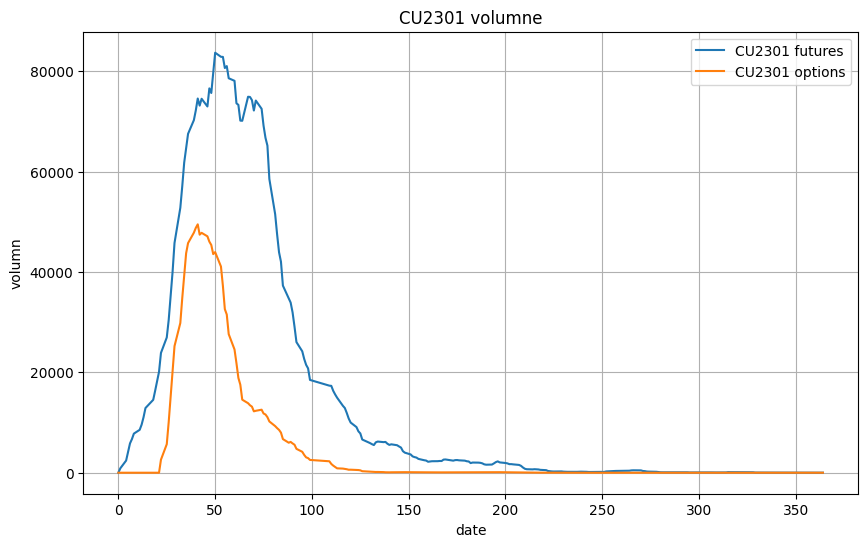

In [7]:
plt.figure(figsize=(10, 6))
smoothed = CU2301_vol.rolling(window=10,min_periods=0).mean()
plt.plot(smoothed, label=smoothed.columns)
plt.title("CU2301 volumne")
plt.xlabel('date')
plt.ylabel('volumn')

plt.legend()

plt.grid(True)

plt.show()

2、i want to get $\tau_1$ and $\tau_2$ (about a month),and the trading volume of options and futures accounts for the highest proportion of the total trading volume between $\tau_1$ and $\tau_2$

In [8]:
# get all data in 2023 and 2024
all_options = fb.data.futuresoptions.info()
underlyingid0 = np.unique(all_options.index.get_level_values('underlyingid'))
underlyingid_lst = [s for s in underlyingid0 if int(s[-4:-2]) == 23 or (int(s[-4:-2]) == 24 and int(s[-2:]) <= 3)]

In [9]:
class Liquid:
    def __init__(self,name):
        self.name = name
        self.options = fb.data.futuresoptions.daily(instrumentid = self.name)
        self.futures = fb.data.futures.daily(instrumentid = self.name)     

    def get_vol_data(self):
        options = self.options.copy()
        futures = self.futures.copy()
        options_vol = options['vol'].groupby(level = 'date').sum()
        options_vol.index=(pd.to_datetime(futures.delist_date.iloc[0]) - pd.to_datetime(options_vol.index)).days
        options_vol.name =  'options'
        futures_vol = futures.loc[:,'vol']
        futures_vol.name =  'futures' 
        futures_vol.index=(pd.to_datetime(futures.delist_date.iloc[0]) - pd.to_datetime(futures_vol.index)).days
        vol=pd.merge(options_vol, futures_vol, how='outer', left_index=True, right_index=True).sort_index()
        vol.loc[0,:]=0
        vol = vol.sort_index().fillna(0)     
        return vol
        
    def examinaion(self):
        a = self.get_vol_data()
        b =  self.get_vol_data()
        return a,b
    
    def get_tau(self):
        # I selected the overlapping area of 10%-90% of options and futures trading volume as the calculated trading date. 
        _vol = self.get_vol_data()
        _vol['options_proper_cumsum'] = 1-(_vol['options']/_vol['options'].sum()).cumsum()
        _vol['futures_proper_cumsum'] = 1-(_vol['futures']/_vol['futures'].sum()).cumsum()
        index_mask = (_vol['options_proper_cumsum'] >= 0.1) & (_vol['options_proper_cumsum'] <= 0.95) & (_vol['futures_proper_cumsum'] >= 0.1) & (_vol['futures_proper_cumsum'] <= 0.95)
        return _vol[index_mask]

    
    def liquid_plot(self):
        _vol = self.get_vol_data()
        _vol_sel = self.get_tau()
        if len(_vol_sel) == 0:
            print('No suitable area')
        else:
            _tau1=_vol_sel.index[0]
            _tau2=_vol_sel.index[-1]
            smoothed = _vol[['options','futures']].rolling(window=10,min_periods=0).mean()
            _min_vol = smoothed.min(axis=1)
            y = _min_vol.values
            x = np.array(_min_vol.index)
            plt.figure(figsize=(10, 6))
            plt.plot(smoothed, label=smoothed.columns)
            plt.fill_between(x, y, where=(x >= _tau1) & (x <= _tau2), color='gray', alpha=0.5)
            plt.title(f"{self.name} volume")
            plt.xlabel('date')
            plt.ylabel('volume')
            plt.legend()
            plt.grid(True)
            plt.show()   
        
    def get_date(self):
        name = self.name
        _vol = self.get_tau()
        if len(_vol) != 0:
            _tau_lst = _vol.index.values
            _futures = self.futures
            date_lst = []
            for i in _tau_lst:
                date_i = pd.Timedelta(days=(i))
                trade_date = _futures.delist_date.iloc[0] - date_i
                date_lst.append(trade_date.strftime('%Y-%m-%d'))
            return date_lst
        else:
            print('No suitable area')
            return None

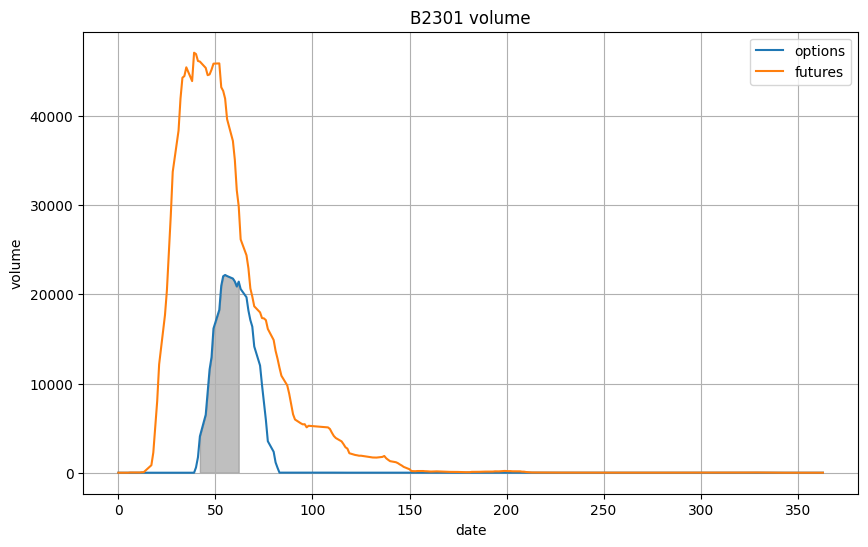

In [10]:
pic_example = Liquid(underlyingid_lst[53])
pic_example.liquid_plot()

3.then, for the different options of the same fulture in one day,for put and cut options with different strike price,are traded with different price and different volume.i will compute the volatility of these options in effective dates.

In [11]:
from scipy.stats import norm
N = norm.cdf

def BS(forward, strike, mat, r, sigma, flag):
    sign = 1
    tau = mat / 360
    discount = np.exp(- r * tau)
    if flag == "P":
        sign = -1
    std_dev = sigma * np.sqrt(tau)

    d1 = np.log(forward/strike) / std_dev + 0.5 * std_dev
    d2 = d1 - std_dev
    result = discount * sign * (forward * N(sign * d1) - strike * N(sign * d2))
    return result

def IV(forward, strike, mat, r, price, flag):
    tau = mat / 360
    discount = np.exp(- r * tau)
    def root_func(x):
        return BS(forward, strike, mat, r, x, flag) - price
    sigma = newton(root_func, 0.2)
    return sigma

In [12]:
from scipy.optimize import newton
# i only calculate the volatility of in-the-money options
def get_BS_vol(name,r=0.02):
    liquid = Liquid(name)
    futures = liquid.futures
    dates = liquid.get_date()
    vol = liquid.get_tau()
    all_result = []
    for date in dates:
        options = liquid.options.loc[(liquid.options.index.get_level_values('date') == date), :]
        # compute weight
        options['weight']=options['vol']/options['vol'].groupby(level= 'call_put').sum()
        forward = futures.loc[date,'settle']
        future_volume = futures.loc[date,'vol']
        option_volume = options['vol'].sum()
        maturity = options.index.get_level_values('maturity')[0]
        mat=(maturity - options.index.get_level_values('date')[0]).days    
        # calculate volatility
        for index in options.index:
            flag=index[2]
            strike=index[3]#strike price
            price=options.loc[index,'settle']#Option price     
            real_option_volume = options.loc[index,'vol']
            weight = options.loc[index,'weight'] 
            if (flag == 'C' and strike < forward) or (flag == 'P' and strike >= forward):
                try:
                    volatility=IV(forward, strike, mat, r, price, flag)
                    day_result = [date,maturity,flag,forward,strike,volatility,option_volume,real_option_volume,future_volume,weight,mat,price]
                    all_result.append(day_result)
                except:
                    pass
    volatility_one = pd.DataFrame(all_result,columns = ['date','maturity','flag','forward','strike','volatility','option_volume','real_option_volume','future_volume','weight','mat','price'])
    volatility_one = volatility_one.set_index(['date','maturity','mat','future_volume','option_volume','forward','flag','strike'])
    return volatility_one

In [13]:
_date = '2024-02-01'
_name = 'CU2403'

liquid = Liquid(_name)
futures = liquid.futures

options = liquid.options.loc[(liquid.options.index.get_level_values('date') == _date), :]
forward = futures.loc[_date,'settle']

maturity = options.index.get_level_values('maturity')[0]
mat=(maturity - options.index.get_level_values('date')[0]).days    

r = 0.02
sigmas = np.linspace(0, 1, 1000)

strike = 70000.0

flag = 'C'

prices = [BS(forward, strike, mat, r, sigma, flag) for sigma in sigmas]


C:\Users\Administrator\AppData\Local\Temp\ipykernel_15484\3960409835.py:12: RuntimeWarning:

divide by zero encountered in scalar divide



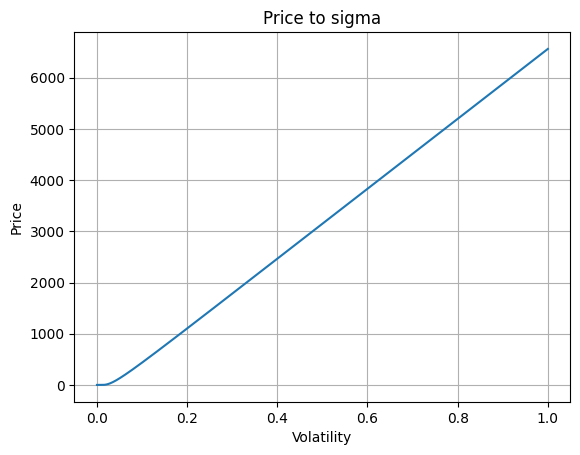

In [15]:
plt.xlabel('Volatility') 
plt.ylabel('Price') 
plt.title("Price to sigma")
plt.plot(sigmas, prices)
plt.grid(True)  
plt.savefig(f"image/Price to sigma.png")
plt.show()

In [17]:
CU_IV = get_BS_vol(_name)
date_CU_IV = CU_IV[CU_IV.index.get_level_values('date') == _date]
date_CU_IV = date_CU_IV.sort_index(level='strike')

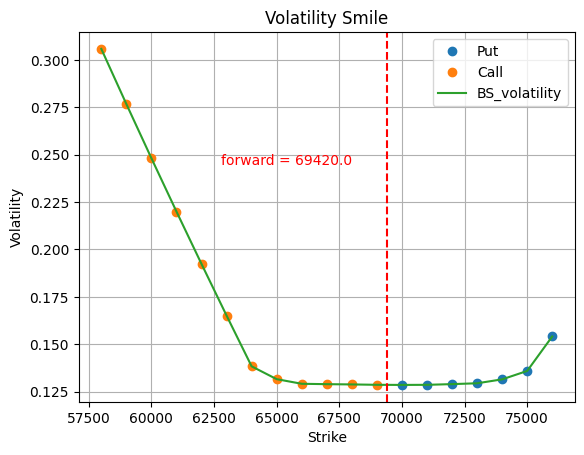

In [23]:
plt.xlabel('Strike') 
plt.ylabel('Volatility') 
plt.title("Volatility Smile")
plt.plot(date_CU_IV[date_CU_IV.index.get_level_values('flag')=='P'].index.get_level_values('strike'),date_CU_IV[date_CU_IV.index.get_level_values('flag')=='P']['volatility'], 'o', label='Put')
plt.plot(date_CU_IV[date_CU_IV.index.get_level_values('flag')=='C'].index.get_level_values('strike'),date_CU_IV[date_CU_IV.index.get_level_values('flag')=='C']['volatility'], 'o', label='Call')
plt.plot(date_CU_IV.index.get_level_values('strike'), date_CU_IV['volatility'],label='BS_volatility')
plt.axvline(x=forward, color='r', linestyle='--')
plt.text(68000, max(date_CU_IV['volatility']) * 0.8, f'forward = {forward}', color='r', ha='right')

plt.grid(True)  
plt.legend()
plt.savefig(f"image/Volatility Smile.png")
plt.show()

4、then i will calibrate the volatility through sabr model.In this step, I would give greater weight to options with greater trading volume

In [40]:
class sabr(object):
    def __init__(self, alpha, beta, rho, volvol):
        self.alpha = alpha
        self.beta = beta
        self.rho = rho
        self.volvol = volvol
        
    def lognormal_vol(self, k, f, t):
        alpha, beta, rho, volvol = self.alpha ,self.beta ,self.rho ,self.volvol
        # Negative strikes or forwards
        if k <= 0 or f <= 0:
            return 0.
        eps = 1e-07
        logfk = np.log(f / k)
        fkbeta = (f*k)**(1 - beta)
        a = (1 - beta)**2 * alpha**2 / (24 * fkbeta)
        b = 0.25 * rho * beta * volvol * alpha / fkbeta**0.5
        c = (2 - 3*rho**2) * volvol**2 / 24
        d = fkbeta**0.5
        v = (1 - beta)**2 * logfk**2 / 24
        w = (1 - beta)**4 * logfk**4 / 1920
        z = volvol * fkbeta**0.5 * logfk / alpha
        if abs(z) > eps:
            vz = alpha * z * (1 + (a + b + c) * t) / (d * (1 + v + w) * self._x(z))
            return vz
        # ATM
        else:
            v0 = alpha * (1 + (a + b + c) * t) / (d * (1 + v + w))
            return v0

    def _x(self, z):
        rho = self.rho
        a = (1 - 2*rho*z + z**2)**.5 + z - rho
        b = 1 - rho
        return np.log(a / b)

In [41]:
initial_guess = [0.01, 0.00, 0.10, 0.5]
x0 = np.array(initial_guess)
bounds = [(0.0001, None), (-0.9999, 0.9999), (0.0001, None), (0.0001, None)]

In [42]:
def get_sabr(name):
    volatility_one = get_BS_vol(name)
    dates = np.unique(volatility_one.index.get_level_values('date'))
    result_all = []
    for date in dates:
        volatility_day = volatility_one.loc[(volatility_one.index.get_level_values('date') == date), :]
        strikes = volatility_day.index.get_level_values('strike')
        forward = volatility_day.index.get_level_values('forward')[0]
        mat = volatility_day.index.get_level_values('mat')[0]
        weight = volatility_day.loc[:,'weight'].values
        vols_BS = volatility_day.loc[:,'volatility'].values
        real_option_volume = volatility_day.loc[:,'real_option_volume'].sum()
        future_volume = volatility_day.index.get_level_values('future_volume')[0]
        option_volume = volatility_day.index.get_level_values('option_volume')[0]
        mat = volatility_day.index.get_level_values('mat')[0]
        
        def vol_square_error(x):
            sabr0 = sabr(x[0], x[1], x[2], x[3])
            vols = np.array([sabr0.lognormal_vol(k_, forward, mat / 360)*100 for k_ in strikes])
            return sum(((vols - vols_BS)*weight)**2)

        res = minimize(vol_square_error, x0, method='L-BFGS-B', bounds=bounds)
        alpha, beta, rho, volvol = res.x
        success = res.success
        resid = res.fun
        result_date = [name, alpha, beta, rho, volvol,success,resid,mat,real_option_volume,option_volume,future_volume]
        result_all.append(result_date)
    sabr_para = pd.DataFrame(result_all,columns = ['name', 'alpha', 'beta', 'rho', 'volvol','success','resid','mat','real_option_volume','option_volume','future_volume'],index = dates)
    sabr_para = sabr_para.set_index(['name','mat'])
    return sabr_para

In [43]:
sabr_para = get_sabr(underlyingid_lst[23])
sabr_para

alpha      beta       rho    volvol  success         resid  \
name   mat                                                                  
AL2303 37   0.177533  0.522016  0.093008  0.000100     True  2.173932e-09   
       36   0.242014  0.490505  0.045608  0.011259     True  3.330566e-09   
       35   0.185543  0.517613  0.210112  0.003821     True  8.214828e-10   
       34   0.202314  0.513076  0.064783  0.000927     True  1.381448e-09   
       33   0.169138  0.527955  0.000661  0.000100     True  7.383566e-10   
       23   0.246362  0.495004  0.173870  0.034191     True  3.247343e-08   
       22   0.125330  0.561913  0.193442  0.025480     True  3.257256e-08   
       21   0.040800  0.652859  0.047591  0.367762     True  1.825350e-05   
       20   0.209786  0.503808  0.251245  0.012967     True  8.223629e-09   
       19   0.352427  0.424850  0.102279  0.755427     True  6.730179e-05   
       16   0.025543  0.722231  0.034160  0.000877     True  6.421346e-10   
       15   0.409191  0.444576  0.014691  0.000204     True  1.799351e-09   
       14   0.036815  0.689703  0.000100  0.020408     True  1.840067e-09   
       13   0.313659  0.470336  0.223276  0.001853     True  5.412836e-10   
       12   0.138837  0.552088  0.054394  0.000100     True  1.904316e-09   
       9    0.199947  0.522547  1.102027  0.000624     True  1.096889e-09   
       8    0.174349  0.531660  0.000111  0.001673     True  3.315710e-09   
       7    0.333140  0.461736  0.031240  0.000186     True  1.451928e-09   
       6    0.081323  0.601266  0.147834  0.005774     True  4.329948e-09   
       5    0.082078  0.594200  0.000100  0.001926     True  1.059813e-08   
       2    0.280639  0.494897  0.416779  0.000606     True  2.886740e-08   
       1    0.112933  0.610780  0.094904  0.004630     True  2.379523e-07   

            real_option_volume  option_volume  future_volume  
name   mat                                                    
AL2303 37               2050.0        14482.0       103108.0  
       36               4413.0        16601.0       101772.0  
       35               4330.0        25167.0       180537.0  
       34               5026.0        35373.0       186750.0  
       33               5357.0        41700.0       176147.0  
       23               3513.0        26523.0       164751.0  
       22               3508.0        30341.0       137394.0  
       21               5467.0        46165.0       134002.0  
       20               4571.0        37661.0       134644.0  
       19               6818.0        52828.0       158680.0  
       16               6700.0        43261.0       184827.0  
       15               6564.0        46798.0       164859.0  
       14               5692.0        53427.0       152360.0  
       13               7436.0        55541.0       180133.0  
       12              12016.0        78765.0       213684.0  
       9                8847.0        63280.0       159276.0  
       8                6348.0        44129.0       109634.0  
       7               12403.0        64615.0       143319.0  
       6               10329.0        53479.0       122463.0  
       5                9874.0        53615.0       107036.0  
       2               14570.0        64258.0       148438.0  
       1               15382.0        60317.0        98747.0

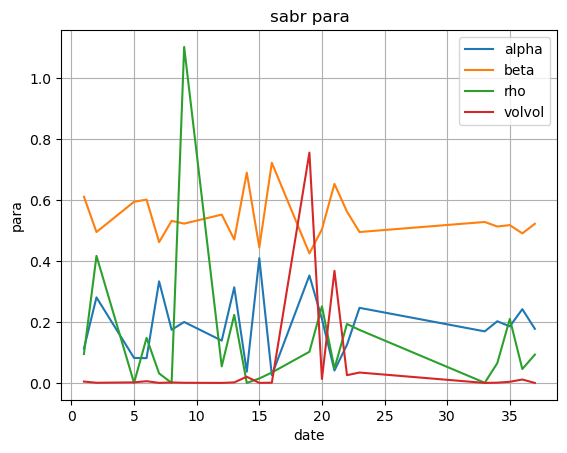

In [44]:
plt.xlabel('date') 
plt.ylabel('para') 
plt.title("sabr para")
plt.plot(sabr_para.index.get_level_values('mat').values,sabr_para.iloc[:,0:4], label=sabr_para.iloc[:,0:4].columns)
plt.grid(True)  
plt.legend()
plt.show()

In [45]:
# then i want to get all sabr date from CU option
# Disable all warnings
warnings.filterwarnings("ignore")
names = [name for name in underlyingid_lst if 'CU' in name]
with Pool(15) as p:
    res_lst = list(tqdm(p.imap(get_sabr,names),total = len(names)))
CU_sabr = pd.concat(res_lst).dropna()

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:47<00:00,  3.18s/it]


In [46]:
CU_sabr[['alpha','beta','rho','volvol']].corr()

,alpha,beta,rho,volvol
alpha,1.000000,0.124138,0.362907,-0.157131
beta,0.124138,1.000000,0.178515,-0.741935
rho,0.362907,0.178515,1.000000,-0.116811
volvol,-0.157131,-0.741935,-0.116811,1.000000


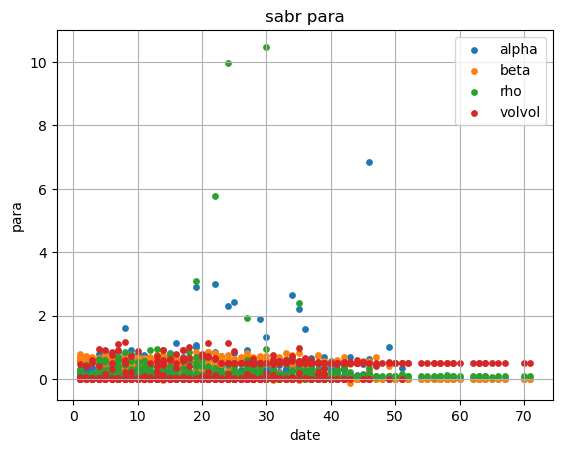

In [47]:
plt.xlabel('date') 
plt.ylabel('para') 
plt.title("sabr para")
plt.scatter(CU_sabr.index.get_level_values('mat').values,CU_sabr['alpha'], label=sabr_para['alpha'].name,s =15)
plt.scatter(CU_sabr.index.get_level_values('mat').values,CU_sabr['beta'], label=sabr_para['beta'].name,s =15)
plt.scatter(CU_sabr.index.get_level_values('mat').values,CU_sabr['rho'], label=sabr_para['rho'].name,s =15)
plt.scatter(CU_sabr.index.get_level_values('mat').values,CU_sabr['volvol'], label=sabr_para['volvol'].name,s =15)
plt.grid(True)  
plt.legend()
plt.show()

for all options,i will compute their sabr parameters during trade days

as for CU,i have compute the all sabr paramaters;the next step is to learn the relations and predict         
as the sabr paramaters is a time series；i will learn a time series model;and more ML models


In [48]:
len(CU_sabr[CU_sabr.index.get_level_values('name') == 'CU2301'])

32

LSTM模型,基于RNN算法(Recurrent neural network)

## keras LSTM:
Input shape=(samples, time_steps, input_dim), where samples represents the number of samples and time_steps represents the time step           
For example, enter shape=(N, 2, 8) and output_dim=32.When return_sequence=True, return (N, 2, 32); when return_sequence=False, return (N, 32), which represents the last output of the output sequence.

In [49]:
PRED_SIZE = 1 #Forecast output 1-day sequence data
OUTPUT_SIZE = 4
TIME_STEPS = 3


def get_batch(train_x,train_y):
    data_len = len(train_x) - TIME_STEPS+1 # may exist some problem;only suit for pred_size = 1
    seq = []
    res = []
    for i in range(data_len):
        seq.append(train_x[i:i + TIME_STEPS])
        res.append(train_y[i:i + TIME_STEPS]) #取后5组数据
        #res.append(train_y[i:i + TIME_STEPS]) 

    seq ,res = np.array(seq),np.array(res)

    return  seq, res

def get_test_train_data(df_data):
    sc = MinMaxScaler(feature_range= (0,1))# scale
    df_data_Purify1 = df_data[df_data['success'] != False]
    df_data_Purify1['mat'] = df_data_Purify1.index.get_level_values('mat')
    df_data_Purify2 = df_data_Purify1[['alpha','beta','rho','volvol','resid','real_option_volume','option_volume','future_volume','mat']]
    df_data_Purify3 = df_data_Purify2[['alpha','beta','rho','volvol','mat']]
    df_data_Purify_ed = df_data_Purify3
    seq_lst = []
    res_lst = []
    training_set = sc.fit_transform(df_data_Purify_ed.drop(index=df_data_Purify_ed.index.get_level_values('name')[-1]))
    test_df = df_data_Purify_ed[df_data_Purify_ed.index.get_level_values('name') == df_data_Purify_ed.index.get_level_values('name')[-1]]
    test_set = sc.transform(test_df)
    total_set = np.concatenate([training_set,test_set], axis=0)
    # Since it is for multiple periods of time, the data needs to be fetched separately.
    _len1 = 0
    _len2 = 0
    for name in np.unique(df_data_Purify_ed.index.get_level_values('name')):
        _len1 += len(df_data_Purify_ed[df_data_Purify_ed.index.get_level_values('name') == name])
        if name == df_data_Purify_ed.index.get_level_values('name')[-1]:
            seq, res = get_batch(total_set[_len2:(_len1-PRED_SIZE)], total_set[(_len2+PRED_SIZE):_len1])
        else:
            seq, res = get_batch(total_set[_len2:(_len1-PRED_SIZE)], total_set[(_len2+PRED_SIZE):_len1][:,0:OUTPUT_SIZE])
        seq_lst.append(seq)
        res_lst.append(res)
        _len2 += len(df_data_Purify_ed[df_data_Purify_ed.index.get_level_values('name') == name])
    # i set the last option as test data 
    train_seq = np.concatenate(seq_lst[:-1], axis=0)
    train_res = np.concatenate(res_lst[:-1], axis=0)
    test_seq = seq_lst[-1]
    test_res = res_lst[-1]
    return train_seq,train_res,test_seq,test_res,sc,test_df

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 3, 24)               │           2,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 3, 24)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 3, 24)               │           4,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 3, 24)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 3, 4)                │             100 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,684 (30.02 KB)

 Trainable params: 7,684 (30.02 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5393 - loss: 0.1114
Epoch 2/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6623 - loss: 0.0948 
Epoch 3/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6505 - loss: 0.0727 
Epoch 4/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6899 - loss: 0.0618 
Epoch 5/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6856 - loss: 0.0531 
Epoch 6/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6798 - loss: 0.0492 
Epoch 7/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6891 - loss: 0.0472 
Epoch 8/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6706 - loss: 0.0461 
Epoch 9/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7019 - loss: 0.0422 
Epoch 10/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7112 - loss: 0.0421 
Epoch 11/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6805 - loss: 0.0395 
Epoch 12/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step -

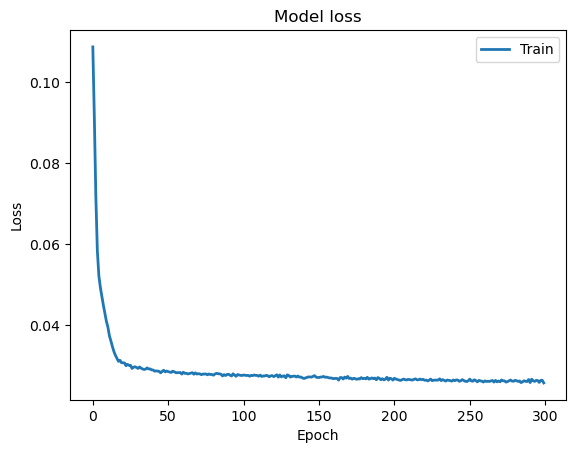

In [50]:
BATCH_START = 0
BATCH_SIZE = 25
INPUT_SIZE = 5 # four para and ond date(maybe more thing)
CELL_SIZE = 24
LR = 0.0001
EPOSE = 300

class KerasMultiLSTM(object):

    def __init__(self,n_steps, input_size, output_size, cell_size, batch_size):
        self.n_steps = n_steps
        self.input_size = input_size
        self.output_size = output_size
        self.cell_size = cell_size # LSTM神经单元数      
        self.batch_size = batch_size # 输入batch_size大小
    
    def model(self):
        
        self.model = Sequential() 
                
        # 不固定batch_size，预测时可以以1条记录进行分析
        self.model.add(LSTM(units = self.cell_size,  activation='relu', return_sequences = True , 
                            input_shape = (self.n_steps, self.input_size))
        )
        self.model.add(Dropout(0.1))        
        self.model.add(LSTM(units = self.cell_size, activation='relu', return_sequences = True))
        self.model.add(Dropout(0.1))        
        # self.model.add(LSTM(units = self.cell_size, activation='relu', return_sequences = True))
        # self.model.add(Dropout(0.1))

        #全连接，输出， add output layer
        self.model.add(TimeDistributed(Dense(self.output_size)))
        self.model.compile(metrics=['accuracy'], loss='mean_squared_error', optimizer='adam')
        self.model.summary()
    
    def train(self,x_train,y_train, epochs ,filename):
        history = self.model.fit(x_train, y_train, epochs = epochs, batch_size = self.batch_size).history
        self.model.save(filename)        
        return history

if __name__ == '__main__':   
    train_x,train_y,text_x,text_y,sc,test_df = get_test_train_data(CU_sabr)
    # 训练集需要是batch_size的倍数
    k = len(train_x)%BATCH_SIZE
    train_x,train_y = train_x[k:], train_y[k:]

    model = KerasMultiLSTM(TIME_STEPS, INPUT_SIZE, OUTPUT_SIZE, CELL_SIZE, BATCH_SIZE)
    model.model()
    history = model.train(train_x,train_y,EPOSE,"lstm-model.keras")
    
    plt.plot(history['loss'], linewidth=2, label='Train')
    plt.legend(loc='upper right')
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.savefig(f"image/LSTM_learning.png")
    plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


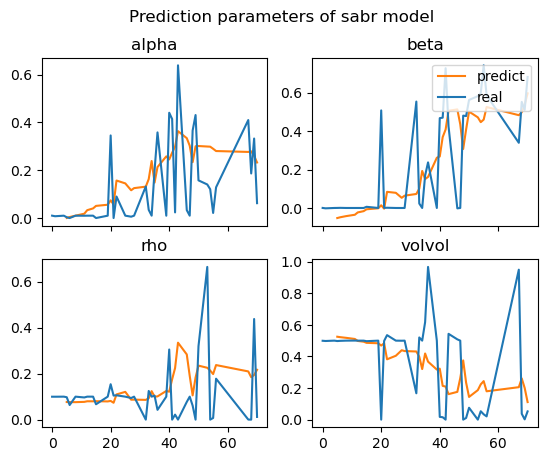

In [51]:
# forecast
## sabr forecast
train_x,train_y,text_x,text_y,sc,test_df = get_test_train_data(CU_sabr)
model = load_model('lstm-model.keras')
pred = model.predict(text_x)
def get_pred_data(pred,text_y,sc):
    pred_neu = pred[:,-1,:]
    text_y_neu = text_y[:,-1,OUTPUT_SIZE:]
    yy = np.concatenate((pred_neu, text_y_neu),axis=1)
    y=sc.inverse_transform(yy)
    return y
pred_array = get_pred_data(pred,text_y,sc)
pred_df = pd.DataFrame(pred_array,columns = test_df.columns)
test_df.index = (test_df['mat'].max()-test_df['mat']).astype(int)
pred_df.index = (test_df['mat'].max()-pred_df['mat']).astype(int)
pred_df['mat'] = pred_df['mat'].astype(int)
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,sharex=True)
fig.suptitle('Prediction parameters of sabr model')
ax1.plot(pred_df['alpha'],'tab:orange')
ax1.plot(test_df['alpha'],'tab:blue')
ax1.set_title('alpha')
ax2.plot(pred_df['beta'],'tab:orange')
ax2.plot(test_df['beta'],'tab:blue')
ax2.set_title('beta')
ax3.plot(pred_df['rho'],'tab:orange')
ax3.plot(test_df['rho'],'tab:blue')
ax3.set_title('rho')
ax4.plot(pred_df['volvol'],'tab:orange')
ax4.plot(test_df['volvol'],'tab:blue')
ax4.set_title('volvol')
ax2.legend(['predict', 'real'], loc='upper right')
plt.savefig(f"image/LSTM_sabr_forecast.png")
plt.show()

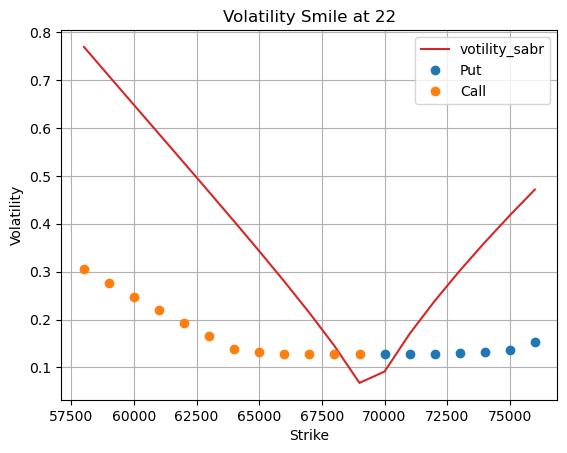

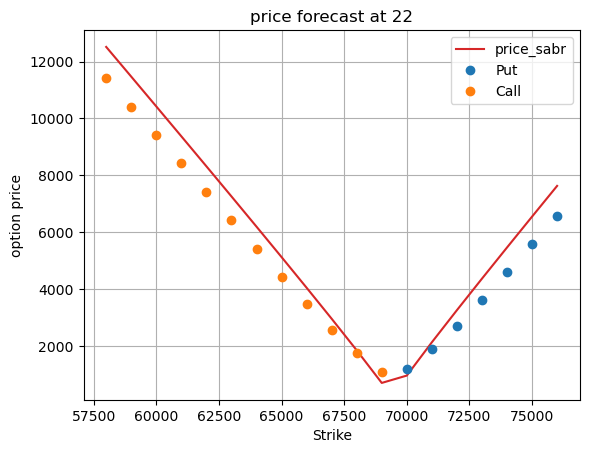

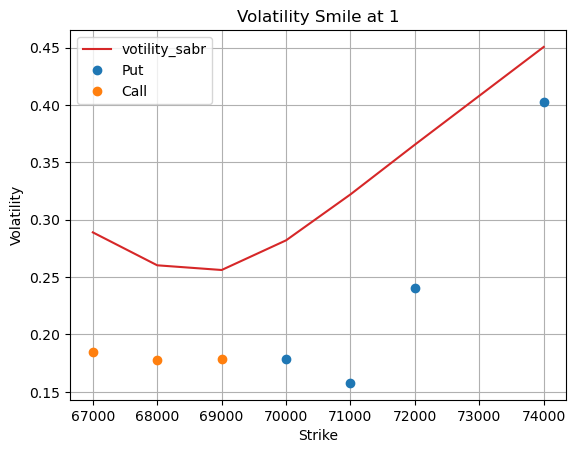

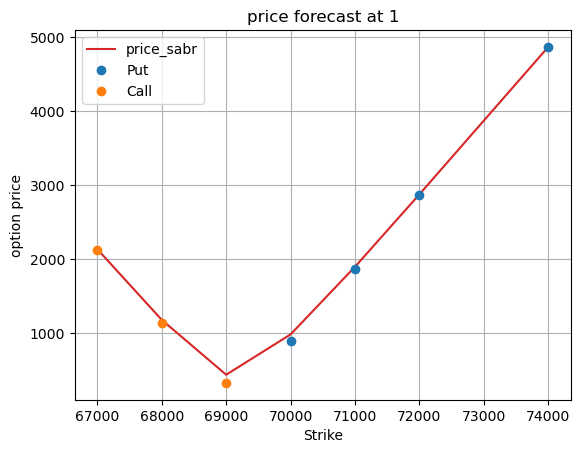

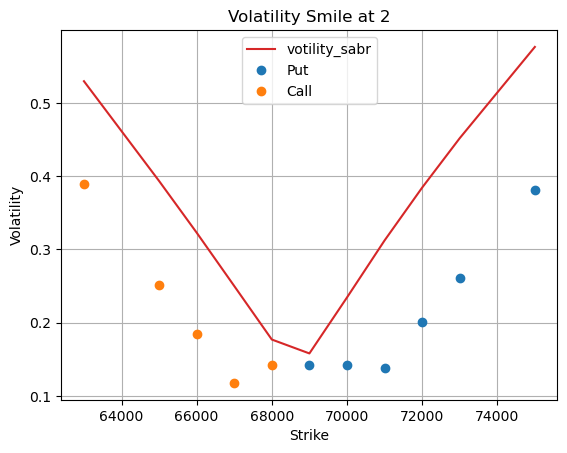

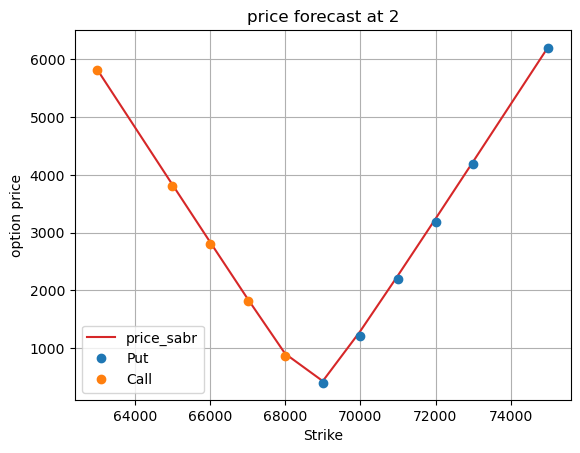

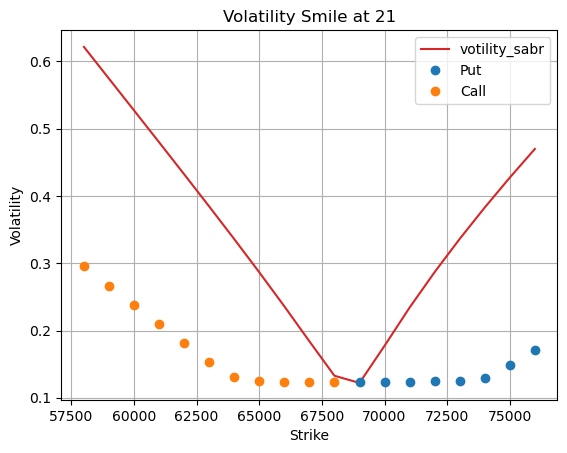

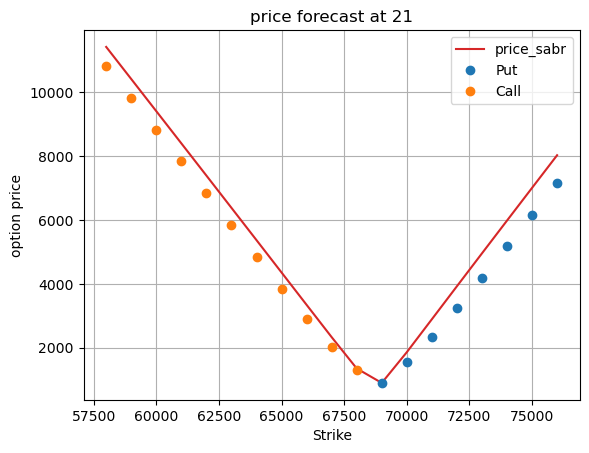

In [52]:
## Black-Scholes IV forecast
## option_price forecast
CU_sabr_pure = CU_sabr[CU_sabr['success'] != False]
pred_name = CU_sabr_pure.index.get_level_values('name')[-1]
real_data = CU_sabr_pure[CU_sabr_pure.index.get_level_values('name') == pred_name].iloc[TIME_STEPS:]
largest_mat = real_data.nlargest(4, 'option_volume').index.get_level_values('mat')
real_BS_volatility = get_BS_vol(pred_name,r=0.02)

for i in range(4):
    mat = largest_mat[i]
    real_BS_volatility_date = real_BS_volatility[real_BS_volatility.index.get_level_values('mat') == mat]
    forward = real_BS_volatility_date.index.get_level_values('forward')[0]
    Strikes = real_BS_volatility_date.index.get_level_values('strike').values
    alpha = pred_df[pred_df['mat']==mat]['alpha'].values
    beta = pred_df[pred_df['mat']==mat]['beta'].values
    rho = pred_df[pred_df['mat']==mat]['rho'].values
    volvol = pred_df[pred_df['mat']==mat]['volvol'].values
    sabr_model = sabr(alpha, beta, rho,volvol)
    real_BS_volatility_date['volatility_sabr']=np.array([sabr_model.lognormal_vol(k_, forward, mat / 360)*100 for k_ in Strikes])
    
    sigma_lst = real_BS_volatility_date['volatility_sabr'].values
    flag_lst = real_BS_volatility_date.index.get_level_values('flag').values
    real_BS_volatility_date['price_sabr'] = np.array([BS(forward, Strikes[i], mat, 0.02, sigma_lst[i], flag_lst[i]) for i in range(len(Strikes))])
    plt.xlabel('Strike') 
    plt.ylabel('Volatility') 
    plt.title(f"Volatility Smile at {mat}")
    plt.plot(real_BS_volatility_date.index.get_level_values('strike'),real_BS_volatility_date['volatility_sabr'],'tab:red', label='votility_sabr')
    plt.plot(real_BS_volatility_date[real_BS_volatility_date.index.get_level_values('flag')=='P'].index.get_level_values('strike'),real_BS_volatility_date[real_BS_volatility_date.index.get_level_values('flag')=='P']['volatility'],'o', label='Put')
    plt.plot(real_BS_volatility_date[real_BS_volatility_date.index.get_level_values('flag')=='C'].index.get_level_values('strike'),real_BS_volatility_date[real_BS_volatility_date.index.get_level_values('flag')=='C']['volatility'],'o', label='Call')
    plt.grid(True)  
    plt.legend()
    plt.savefig(f"image/Volatility Smile at {mat}.png")
    plt.show()
    
    plt.xlabel('Strike') 
    plt.ylabel('option price') 
    plt.title(f"price forecast at {mat}")
    plt.plot(real_BS_volatility_date.index.get_level_values('strike'),real_BS_volatility_date['price_sabr'],'tab:red', label='price_sabr')
    plt.plot(real_BS_volatility_date[real_BS_volatility_date.index.get_level_values('flag')=='P'].index.get_level_values('strike'),real_BS_volatility_date[real_BS_volatility_date.index.get_level_values('flag')=='P']['price'],'o', label='Put')
    plt.plot(real_BS_volatility_date[real_BS_volatility_date.index.get_level_values('flag')=='C'].index.get_level_values('strike'),real_BS_volatility_date[real_BS_volatility_date.index.get_level_values('flag')=='C']['price'],'o', label='Call')
    plt.grid(True)  
    plt.legend()
    plt.savefig(f"image/price forecast at {mat}.png")
    plt.show()


# fold

5.then i will take all options of copper futures into account;first i want to know the proper trade date

the first idea:for the real data,i know the volume of option and future before; i want to choose one day to start compute volatility; the volume have differen size;so only consider the volumn is meaningless；it is easy to see,the volume's proportion relate to date;then i want to extract a little useful information from the trading volume of futures and options（maybe $\frac{volumn_{futures}}{volumn_{options}}$ ）

In [ ]:
vol_lst = []
names = []
names_id = []
for name in tqdm(underlyingid_lst):
    liquid = total_liquid(name)
    vol = liquid.get_tau_three()
    if vol is None:
        pass
    else:
        vol_lst.append(vol)
        names.append(name)
        names_id.append(name[:-4])
# index = pd.MultiIndex.from_arrays([names_id,proportion_all,names], names=('id', 'proportion','underlyingid'))
keys = [(names[i],names_id[i]) for i in range(len(names))]
tau_all_df = pd.concat(vol_lst, keys=keys, names=['name', 'name_id'])

In [ ]:
tau_all_df.loc[tau_all_df.index.get_level_values('id') == 'CU']

as we can see for different underlying, the proper date is different;then i will create a method to choose the start date and the end date

my requirements：           
1、[start_date,end_date] contains at least 70% of trading volume (The geometric mean of the proportion of options trading volume and the proportion of futures trading volume)           
2、(end_date - start_date) is as smaller as better      
3、(end_date - start_date) is bigger than 30 to get enough sample points     

In [ ]:
# first,get the data set
names = tau_all_df.loc[tau_all_df.index.get_level_values('id') == 'CU'].index.get_level_values('underlyingid')
proportion_lst = []
fit_lst = []
for name in tqdm(names):
    liquid = total_liquid(name)
    proportion = liquid.get_propor()
    # I will remove some useless information based on option_volume
    zeros_mask = (proportion['option_volume'].shift(1)+proportion['option_volume'].shift(-1)).fillna(0) != 0
    # proportion_fit = proportion[zeros_mask]
    proportion_fit = proportion
    if tau_lst is None:
        pass
    else:
        proportion_fit['option_future_volume'] = proportion_fit['option_volume']/proportion_fit['future_volume']
        proportion_fit['log_date'] = np.log(proportion_fit.index)
        proportion_fit['option_volume_proper'] = proportion_fit['option_volume']/proportion_fit['option_volume'].sum()
        proportion_fit['future_volume_proper'] = proportion_fit['future_volume']/proportion_fit['future_volume'].sum()
        proportion_fit['option_volume_proper_cumsum'] = proportion_fit['option_volume_proper'][::-1].cumsum()
        proportion_fit['future_volume_proper_cumsum'] = proportion_fit['future_volume_proper'][::-1].cumsum()
        
        proportion_fit['option_volume_change'] = proportion_fit['option_volume']/proportion_fit['option_volume'].shift(-1) -1
        proportion_fit['future_volume_change'] = proportion_fit['future_volume']/proportion_fit['future_volume'].shift(-1) -1
        proportion_fit['option_future_volume_cumsum'] = proportion_fit['option_future_volume'][::-1].cumsum()
        proportion_fit['option_future_volume_cumsum_op'] = proportion_fit['option_future_volume_cumsum']-proportion_fit['option_future_volume_cumsum'][::-1].expanding().mean()

        # moreover ,When cum_propor is close to 0 or 1, it is difficult to fit. In fact, we do not need this part of the data.
        fit_mask = (proportion_fit['cum_propor']>0.03)
        fit_lst.append(fit_mask)
        proportion_lst.append(proportion_fit)

    
proportion_df = pd.concat(proportion_lst,axis =0)

In [ ]:
proportion_df

In [ ]:
# # 创建一个 4x4 的子图
# fig, ax = plt.subplots(4, 4)

# # 遍历每个子图并添加标签
# for i in range(4):
#     for j in range(4):
#         ax[i, j].text(0.5, 0.5, f'{i},{j}', ha='center', va='center', fontsize=10)

plt.xlabel('date') 
plt.ylabel('option_volume_proper_cumsum') 
plt.title("option_volume_proper_cumsum")
for i in range(len(proportion_lst)):
    plt.plot(proportion_lst[i][fit_lst[i]].index,proportion_lst[i][fit_lst[i]].option_volume_proper_cumsum)
plt.grid(True)  
plt.show()

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="seaborn")
# histogram with seaborn
sns.pairplot(data=proportion_df.reset_index()[['log_date','option_volume_proper_cumsum']]);
sns.pairplot(data=proportion_df.reset_index()[['log_date','future_volume_proper_cumsum']]);
sns.pairplot(data=proportion_df.reset_index()[['date','option_volume_proper_cumsum']]);
sns.pairplot(data=proportion_df.reset_index()[['date','future_volume_proper_cumsum']]);

In [ ]:
plt.xlabel('date') 
plt.ylabel('option_volume_proper_cumsum') 
plt.title("option_volume_proper_cumsum")
for i in range(len(proportion_lst)):
    plt.plot(proportion_lst[i][fit_lst[i]].index,proportion_lst[i][fit_lst[i]].option_volume_proper_cumsum)
plt.grid(True)  
plt.show()

In [ ]:
plt.xlabel('log(date)') 
plt.ylabel('option_volume_proper_cumsum') 
plt.title("option_volume_proper_cumsum")
for i in range(len(proportion_lst)):
    plt.scatter(proportion_lst[i][fit_lst[i]].log_date,proportion_lst[i][fit_lst[i]].option_volume_proper_cumsum,s= 15)
plt.grid(True)  
plt.show()

In [ ]:
plt.xlabel('volume') 
plt.ylabel('cum_propor') 
plt.title("cum_propor")
for i in range(len(proportion_lst)):
    plt.scatter(proportion_lst[i][fit_lst[i]].total_volume,proportion_lst[i][fit_lst[i]].cum_propor,s= 15)
plt.grid(True)  
plt.show()

In [ ]:
plt.ylabel('cum_volume') 
plt.xlabel('cum_propor') 
plt.title("cum_propor")
for i in range(len(proportion_lst)):
    plt.scatter(proportion_lst[i][fit_lst[i]].total_volume_cumsum,proportion_lst[i][fit_lst[i]].cum_propor,s= 15)
plt.grid(True)  
plt.show()

In [ ]:
plt.ylabel('cum_volume') 
plt.xlabel('cum_propor') 
plt.title("cum_propor")
for i in range(len(proportion_lst)):
    plt.scatter(proportion_lst[i][fit_lst[i]].total_volume_cumsum_op,proportion_lst[i][fit_lst[i]].cum_propor,s= 15) 
plt.grid(True)  
plt.show()

In [ ]:
plt.xlabel('option_volume_change') 
plt.ylabel('cum_propor') 
plt.title("cum_propor")
for i in range(len(proportion_lst)):
    plt.scatter(proportion_lst[i][fit_lst[i]].option_volume_change,proportion_lst[i][fit_lst[i]].cum_propor,s= 15)
plt.grid(True)  
plt.show()

In [ ]:
plt.xlabel('future_volume_change') 
plt.ylabel('cum_propor') 
plt.title("cum_propor")
for i in range(len(proportion_lst)):
    plt.scatter(proportion_lst[i][fit_lst[i]].future_volume_change,proportion_lst[i][fit_lst[i]].cum_propor,s= 15)
plt.grid(True)  
plt.show()

i find two effective factors:log(date)、cumsum(option_volume/future_volume)           
it is easy to find the linear relationship
                                        

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold

class helper_fit(object):
    def __init__(self,data1,data2 = None):
        if data2 is None:
            x = np.array(data1.index)
            y = np.array(data1)
        else:
            if isinstance(data1, np.ndarray):
                x = data1
            else:
                x = np.array(data1)
            if isinstance(data2, np.ndarray):
                y = data2
            else:
                y = np.array(data2)
            if x.ndim == 1:
                x = x[:, np.newaxis]
            # dropna
            x_drna = ~np.isnan(x).any(axis=1) & np.isfinite(x).all(axis=1)
            y_drna = ~np.isnan(y) & np.isfinite(y)
            drnan_indices = x_drna*y_drna
            self.x = x[drnan_indices]
            self.y = y[drnan_indices]
    def data_partition(self):
        kf = KFold(n_splits=10)
        for train_index, test_index in kf.split(self.x):
            x_train, x_test = self.x[train_index], self.x[test_index]
            y_train, y_test = self.y[train_index], self.y[test_index]
            break
        return x_train, x_test, y_train, y_test
    def evaluate(self):
        mse = []
        R_2 = []
        for i in range(100):
            x_train, x_test, y_train, y_test = self.data_partition()
            model = LinearRegression()
            hypothesis = model.fit(x_train, y_train)
            hpyTrain = model.predict(x_train)
            hpyTest = model.predict(x_test)  
            ssResTest = sum((hpyTest - y_test)**2)                   
            ssTotTest = sum((y_test - np.mean(y_test))**2)            
            Rsquare = 1 - ssResTest / ssTotTest  
            mse.append(ssResTest)
            R_2.append(Rsquare)
        print(f'mse of test set：{np.mean(mse)}')
        print(f'Rsquare of test set：{np.mean(R_2)}')

In [ ]:
print('only take date into account')
eva = helper_fit(proportion_df['log_date'],proportion_df['cum_propor'])
eva.evaluate()

print('\ntake date and date**2 into account')
eva = helper_fit(pd.concat([proportion_df['log_date'],proportion_df['log_date']**2],axis = 1),proportion_df['cum_propor'])
eva.evaluate()

proportion_df['log_date'] = np.log(proportion_df.index)
print('\ntake both date and option_future_volume_cumsum into account')
eva = helper_fit(proportion_df[['option_future_volume_cumsum','log_date']],proportion_df['cum_propor'])
eva.evaluate()

print('\ntake both date and option_future_volume_cumsum_op into account')
eva = helper_fit(proportion_df[['option_future_volume_cumsum_op','log_date']],proportion_df['cum_propor'])
eva.evaluate()

print('\ntake date, date**2 and option_future_volume_cumsum_op into account')
eva = helper_fit(pd.concat([proportion_df['log_date'],proportion_df['log_date']**2,proportion_df['option_future_volume_cumsum_op']],axis = 1),proportion_df['cum_propor'])
eva.evaluate()

print('\nonly take cum_volume_op into account')
eva = helper_fit(proportion_df['option_future_volume_cumsum_op'],proportion_df['cum_propor'])
eva.evaluate()

print('\ntake cum_volume_op and cum_volume_op**2 into account')
eva = helper_fit(pd.concat([proportion_df['option_future_volume_cumsum_op'],proportion_df['option_future_volume_cumsum_op']**2],axis = 1),proportion_df['cum_propor'])
eva.evaluate()

as we can see;take date and date**2 into account is best

In [ ]:
def get_proper_day(data):
    eva = helper_fit(pd.concat([data['log_date'],data['log_date']**2],axis = 1),data['cum_propor'])
    # eva = helper_fit(data['log_date'],data['cum_propor'])
    x = eva.x
    y = eva.y
    model = LinearRegression()
    hypothesis = model.fit(x, y)
    start_date = data.index.min()+1
    end_date = data.index.max()+1
    x_new = np.array([[np.log(x),np.log(x)**2] for x in range(start_date,end_date)])
    hpy = model.predict(x_new)
    hpy_df = pd.DataFrame({'date':range(start_date,end_date),'predict':hpy})
    hpy_df.set_index('date', inplace=True)
    return hpy_df

In [ ]:
helper_fit(data['log_date'],data['cum_propor']).x

In [ ]:
a = get_proper_day(proportion_df)

In [ ]:
a.shift(30).idxmax()

In [ ]:
a

In [ ]:
b = pd.concat([proportion_df['log_date'],proportion_df['log_date']**2],axis = 1)

In [ ]:
np.array(b)

In [ ]:
b

In [ ]:
start_date = data.index.min()+1
end_date = data.index.max()+1
x_new = np.array([[np.log(x),np.log(x)**2] for x in range(start_date,end_date)])

In [ ]:
x_new